# Base blockchain -- trace data

By [Johnnatan Messias](https://johnnatan-messias.github.io), July 16th

### Base Chain Trace Columns

These columns likely come from Base chain and represent execution traces from transaction replays (e.g., via `debug_traceTransaction`). Below is a description of each column:

| Column           | Description                                                                |
| ---------------- | -------------------------------------------------------------------------- |
| `block_time`     | Timestamp of the block in human-readable format.                           |
| `block_number`   | The block number where the trace occurred.                                 |
| `value`          | Amount of ETH (in wei) transferred in the trace.                           |
| `gas`            | Gas limit specified for this trace.                                        |
| `gas_used`       | Actual gas consumed by the operation.                                      |
| `block_hash`     | The hash of the block containing this trace.                               |
| `success`        | Indicates if this specific trace step was successful (`True`/`False`).     |
| `tx_index`       | Transaction index within the block.                                        |
| `sub_traces`     | Number of sub-calls from this trace (e.g., internal contract calls).       |
| `error`          | Error message if the trace failed (e.g., 'revert').                        |
| `tx_success`     | Whether the entire transaction was successful.                             |
| `tx_hash`        | Hash of the transaction this trace belongs to.                             |
| `from`           | Address that initiated this trace.                                         |
| `to`             | Address receiving the call/message.                                        |
| `trace_address`  | Path within the transaction trace tree (e.g., `[0, 1]` for a nested call). |
| `type`           | Type of trace: `call`, `create`, `suicide`, etc.                           |
| `address`        | For `create` or `suicide`, the address being created/destroyed.            |
| `code`           | Contract bytecode (if available).                                          |
| `call_type`      | E.g., `call`, `delegatecall`, `staticcall`, etc.                           |
| `input`          | Hex-encoded input data to the contract.                                    |
| `output`         | Hex-encoded output returned by the call.                                   |
| `refund_address` | If ETH is being refunded (e.g., during contract destruction).              |
| `block_date`     | Date extracted from `block_time` (e.g., `YYYY-MM-DD`).                     |
| `to_label`       | Human-readable label for the `to` address, if available.                   |
| `from_label`     | Human-readable label for the `from` address, if available.                 |


In [ ]:
# The "from" and "to" column is already the parsed traces gathered from the input.

In [1]:
import os
import json
import pandas as pd
import polars as pl

In [2]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "data"))
os.makedirs(data_dir, exist_ok=True)

In [3]:
filedir = os.path.join(data_dir, "labels", "account-labels.json")
with open(filedir) as f:
    labels = json.load(f)
print("There are {} labels in our dataset.".format(len(labels)))
labels

There are 501 labels in our dataset.


{'0x2ce6311ddae708829bc0784c967b7d77d19fd779': 'Circle',
 '0x498581ff718922c3f8e6a244956af099b2652b2b': 'Uniswap V4: Pool Manager',
 '0x16613524e02ad97edfef371bc883f2f5d6c480a5': 'Aerodrome: Voter',
 '0x000000000022d473030f116ddee9f6b43ac78ba3': 'Uniswap V3: Permit2',
 '0xec8d8d4b215727f3476ff0ab41c406fa99b4272c': 'BMX: Vault',
 '0x0000000000000000000000000000000000000001': 'Null',
 '0xbbbbbbbbbb9cc5e90e3b3af64bdaf62c37eeffcb': 'Morpho: Morpho',
 '0x420dd381b31aef6683db6b902084cb0ffece40da': 'Aerodrome: Pool Factory',
 '0x590830dfdf9a3f68afcdde2694773debdf267774': 'Giza: GIZA Token',
 '0x6e4141d33021b52c91c28608403db4a0ffb50ec6': 'KyberSwap: Aggregator Executor',
 '0x6ff5693b99212da76ad316178a184ab56d299b43': 'Uniswap V4: Universal Router',
 '0x833589fcd6edb6e08f4c7c32d4f71b54bda02913': 'USDC (USDC)',
 '0x0555e30da8f98308edb960aa94c0db47230d2b9c': 'Wrapped BTC (WBTC)',
 '0xc1cba3fcea344f92d9239c08c0568f6f2f0ee452': 'Wrapped liquid staked Ether 2.0 (wstETH)',
 '0x04c0599ae5a44757c0af6f9

In [4]:
schema = pl.Schema([('block_time', pl.String),
                    ('block_number', pl.Int64),
                    ('value', pl.Float64),
                    ('gas', pl.Int64),
                    ('gas_used', pl.Int64),
                    ('block_hash', pl.String),
                    ('success', pl.Boolean),
                    ('tx_index', pl.Int64),
                    ('sub_traces', pl.Int64),
                    ('error', pl.String),
                    ('tx_success', pl.Boolean),
                    ('tx_hash', pl.String),
                    ('from', pl.String),
                    ('to', pl.String),
                    ('trace_address', pl.String),
                    ('type', pl.String),
                    ('address', pl.String),
                    ('code', pl.String),
                    ('call_type', pl.String),
                    ('input', pl.String),
                    ('output', pl.String),
                    ('refund_address', pl.String),
                    ('block_date', pl.String)])

In [5]:
fieldir = os.path.join(data_dir, "base-revert-traces.csv")
df = pl.scan_csv(fieldir, schema=schema)
df = df.with_columns(
    pl.col("block_time").str.strptime(
        pl.Datetime(), "%Y-%m-%d %H:%M:%S%.3f UTC"),
    to_label=pl.col("to").map_elements(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]), return_dtype=pl.String),
    from_label=pl.col("from").map_elements(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]), return_dtype=pl.String),
    function_selector=pl.col("input").str.slice(0, 10),
    trace_depth=pl.col("trace_address").map_elements(lambda x: 0 if (
        x == "" or x == "[]") else x.count(" ") + 1, return_dtype=pl.Int8)
)
# Group by transaction and sort by trace depth (to reconstruct call flow)
df = df.sort(["block_number", "tx_index", "tx_hash", "trace_depth"])
print("There are {} columns and {} rows.".format(
    len(df.collect_schema()), df.select(pl.len()).collect().item()))
df.head().collect()

There are 27 columns and 212052 rows.


block_time,block_number,value,gas,gas_used,block_hash,success,tx_index,sub_traces,error,tx_success,tx_hash,from,to,trace_address,type,address,code,call_type,input,output,refund_address,block_date,to_label,from_label,function_selector,trace_depth
datetime[μs],i64,f64,i64,i64,str,bool,i64,i64,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i8
2025-05-20 17:00:01,30485527,0.0,10500000,215430,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,"""execution reverted""",false,"""0x6aaa7e785df914943d12dfb0b825…","""0xfe9d977baa824e683db0149cb80f…","""0xd1a0d188e861ed9d15773a2f3574…","""[]""","""call""",null,null,"""call""","""0x64ee4b8000000000000000000000…","""0x08c379a000000000000000000000…",null,"""2025-05-20""","""0xd1a0...ba8f""","""0xfe9d...640d""","""0x64ee4b80""",0
2025-05-20 17:00:01,30485527,0.0,10309879,188903,"""0xcc299ee97244c721c649a8e18f10…",false,46,16,"""execution reverted""",false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x5545a4ab5cd3f6e7db0883e73ea4…","""[0]""","""call""",null,null,"""delegatecall""","""0x64ee4b8000000000000000000000…","""0x08c379a000000000000000000000…",null,"""2025-05-20""","""0x5545...70a9""","""0xd1a0...ba8f""","""0x64ee4b80""",1
2025-05-20 17:00:01,30485527,null,10119325,8797,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e11001cfbb6de5737327c59e10a…","""[0 0]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...b5d3""","""0xd1a0...ba8f""","""0x9d63848a""",2
2025-05-20 17:00:01,30485527,null,10093763,6297,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e11226fe3d85142b734abce6e58…","""[0 2]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...d1b4""","""0xd1a0...ba8f""","""0x9d63848a""",2
2025-05-20 17:00:01,30485527,null,10083197,6309,"""0xcc299ee97244c721c649a8e18f10…",false,46,1,null,false,"""0x6aaa7e785df914943d12dfb0b825…","""0xd1a0d188e861ed9d15773a2f3574…","""0x3e1133ac082716ddc3114bbefeed…","""[0 3]""","""call""",null,null,"""staticcall""","""0x9d63848a""","""0x0000000000000000000000000000…",null,"""2025-05-20""","""0x3e11...9cb1""","""0xd1a0...ba8f""","""0x9d63848a""",2


In [6]:
df.group_by("call_type").agg(pl.len()).sort(
    by="len", descending=True).collect()

call_type,len
str,u32
"""staticcall""",83323
"""call""",81544
"""delegatecall""",47184
null,1


In [7]:
df.group_by("error").agg(pl.len()).sort(
    by="len", descending=True).collect()

error,len
str,u32
null,182415
"""execution reverted""",29001
"""out of gas""",499
"""ReentrancySentryOOG""",56
"""out of gas: not enough gas for…",55
"""insufficient balance for trans…",12
"""write protection""",8
"""StateChangeDuringStaticCall""",3
"""out of gas: out of gas""",2


In [8]:
df.group_by("address").agg(pl.len()).sort(
    by="len", descending=True).collect()

address,len
str,u32
null,212052


In [9]:
# There are only failed traces
df.group_by("success").agg(pl.len()).collect()

success,len
bool,u32
false,212052


In [10]:
# There are only failed traces
df.group_by("tx_success").agg(pl.len()).collect()

tx_success,len
bool,u32
false,212052


In [11]:
df.group_by("from_label").agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

from_label,len
str,u32
"""0xb7b8...f463""",37058
"""USDC (USDC)""",22011
"""Uniswap V4: Pool Manager""",9172
"""0xad4f...915d""",4488
"""0x2a84...795b""",4433
"""KyberSwap: Aggregator Executor""",4426
"""0x4f1c...d037""",4016
"""0x5e7b...809a""",4003
"""0xdb45...6b5d""",2832


In [12]:
df.group_by("to_label").agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

to_label,len
str,u32
"""Circle""",22103
"""USDC (USDC)""",21997
"""Wrapped Ether (WETH)""",20714
"""Uniswap V4: Pool Manager""",18415
"""0xb7b8...f463""",10172
"""0xec8e...5831""",6855
"""0x5e7b...809a""",3129
"""Coinbase Wrapped BTC (cbBTC)""",1930
"""0x7458...aa72""",1929


In [13]:
df.group_by(["from_label", "to_label"]).agg(pl.len()).sort(
    by="len", descending=True).head(10).collect()

from_label,to_label,len
str,str,u32
"""USDC (USDC)""","""Circle""",21983
"""0xb7b8...f463""","""Uniswap V4: Pool Manager""",16370
"""0xb7b8...f463""","""Wrapped Ether (WETH)""",9763
"""0xb7b8...f463""","""USDC (USDC)""",9087
"""Uniswap V4: Pool Manager""","""0xb7b8...f463""",4131
"""Uniswap V4: Pool Manager""","""USDC (USDC)""",3915
"""Coinbase Wrapped BTC (cbBTC)""","""0x7458...aa72""",1929
"""0x5e7b...809a""","""Aerodrome: Voter""",1824
"""USD Base Coin (USDbC)""","""0x1833...b463""",1823


In [14]:
data = df.head(50).collect()
for row in data.iter_rows(named=True):
    print(row["tx_success"], row['tx_hash'],
          row["from_label"], "->", row["to_label"])

False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xfe9d...640d -> 0xd1a0...ba8f
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x5545...70a9
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> Coinbase Wrapped BTC (cbBTC)
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...e6c9
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...dbf1
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x1c61...0d67
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...b5d3
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> USDC (USDC)
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb84b605d525405a027b697c 0xd1a0...ba8f -> 0x3e11...e6c9
False 0x6aaa7e785df914943d12dfb0b825b5d43f196b96eb8

In [15]:
column = "from"
data = (df
        .filter(pl.col('to_label').eq("Unknown") | pl.col("from_label").eq("Unknown"))
        .group_by(column)
        .agg(pl.len().alias('freq'))
        .sort(by='freq', descending=True).head(40).collect())
for row in data.iter_rows(named=True):
    print(row[column], row['freq'])

In [16]:
# Hex-encoded input data. The first 4 bytes (8 hex chars) are the function selector
(df
 .group_by("function_selector")
 .agg(pl.len())
 .sort(by="len", descending=True)
 .head(10)
 ).collect()

function_selector,len
str,u32
"""0x70a08231""",56944
"""0xa9059cbb""",21522
"""0x128acb08""",7903
"""0x3850c7bd""",7323
"""0x23b872dd""",6100
"""0xf135baaa""",4607
"""0x48c89491""",3724
"""0x91dd7346""",3453
"""0xf3cd914c""",3280


In [17]:
(df
 .filter(pl.col("call_type").eq("call"))
 .group_by("function_selector")
 .agg(pl.len())
 .sort(by="len", descending=True)
 .head(10)
 ).collect()

function_selector,len
str,u32
"""0xa9059cbb""",13980
"""0x128acb08""",6668
"""0x23b872dd""",4018
"""0x48c89491""",3724
"""0x91dd7346""",3285
"""0xf3cd914c""",3280
"""0x34df7d41""",2943
"""0x""",2714
"""0xfa461e33""",2566


In [ ]:
# Check the signatures for each of the protocols specifically.

In [18]:
import web3


def get_sig(sig):
    return web3.Web3.keccak(text=sig).hex()


get_sig("unlockCallback(bytes)")

'91dd7346410d7d3e1561ab65859d8ebbee84f666c7eb10ddc6d9424bc35ec2ee'

In [19]:
import requests


def decode_selector(selector):
    if selector.startswith("0x"):
        selector = selector[2:]
    url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature=0x{selector}"
    res = requests.get(url)
    results = res.json().get("results", [])
    if results:
        return results

In [20]:
decode_selector('0x91dd7346')

[{'id': 1130965,
  'created_at': '2025-01-31T21:49:56.619365Z',
  'text_signature': 'unlockCallback(bytes)',
  'hex_signature': '0x91dd7346',
  'bytes_signature': '\x91ÝsF'}]

## Graph network analysis


In [40]:
import networkx as nx

# Extract relevant columns
edges_df = df.select([
    "from_label", "to_label", "from", "to", "value", "gas_used", "input", "tx_hash"
]).filter(
    (pl.col("from").is_not_null()) & (pl.col("to").is_not_null())
)

# Add function selector column
edges_df = edges_df.with_columns([
    pl.col("input").str.slice(0, 10).alias("function_selector")
])

# Build graph
G = nx.DiGraph()

for row in edges_df.collect().iter_rows(named=True):
    G.add_edge(
        row['from_label'], row['to_label'],
        tx_hash=row['tx_hash'],
        value=float(row['value']) if row['value'] else 0,
        gas=float(row['gas_used']) if row['gas_used'] else 0,
        selector=row['function_selector']
    )

In [ ]:
# Consider other parser for 

In [42]:
# Use common function selectors:

# 0xa9059cbb: transfer(address,uint256)
# 0x23b872dd: transferFrom(address,address,uint256)

token_calls = df.filter(
    pl.col("function_selector").is_in(["0xa9059cbb", "0x23b872dd"])
)

# Decode partial transfer information
# Example: get destination address (bytes 5–36) and amount (bytes 37–68)


def decode_transfer_input(input_hex: str):
    if len(input_hex) < 138:
        return None, None
    to_address = "0x" + input_hex[34:74][-40:]
    value = int(input_hex[74:138], 16)
    return to_address, value


decoded = token_calls.select([
    "from", "input", "tx_hash"
]).with_columns([
    pl.col("input").map_elements(
        lambda x: decode_transfer_input(x)[0], return_dtype=pl.String).alias("token_to"),
    pl.col("input").map_elements(
        lambda x: decode_transfer_input(x)[1], return_dtype=pl.Float64).alias("token_value")
])
decoded.collect().head()

from,input,tx_hash,token_to,token_value
str,str,str,str,f64
"""0x1231deb6f5749ef6ce6943a275a1…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…","""0x242f656b099a188bfc523bd56f84…",1.0387e47
"""0x1231deb6f5749ef6ce6943a275a1…","""0xa9059cbb00000000000000000000…","""0x068fe17b56909063edc72a258e55…","""0x242f656b099a188bfc523bd56f84…",991784.0
"""0x833589fcd6edb6e08f4c7c32d4f7…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…","""0x242f656b099a188bfc523bd56f84…",1.0387e47
"""0x0a6d96e7f4d7b96cfe42185df61e…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…","""0x1231deb6f5749ef6ce6943a275a1…",5.9534e46
"""0x6131b5fae19ea4f9d964eac0408e…","""0x23b872dd00000000000000000000…","""0x068fe17b56909063edc72a258e55…","""0x1231deb6f5749ef6ce6943a275a1…",6.2944e47


In [ ]:
# Some bots are calling Uniswap more often, then it would be good to show the connectivity of these bots? Normal trader vs Bots. Can we show the graph network differences for both bots and normal traders?
# Heuristics to detect bots? Can we come up with our own? How they compare with existing heuristics (e.g., Flashbots).
# Make a list of possible heuristics we could test in our graph network analysis.

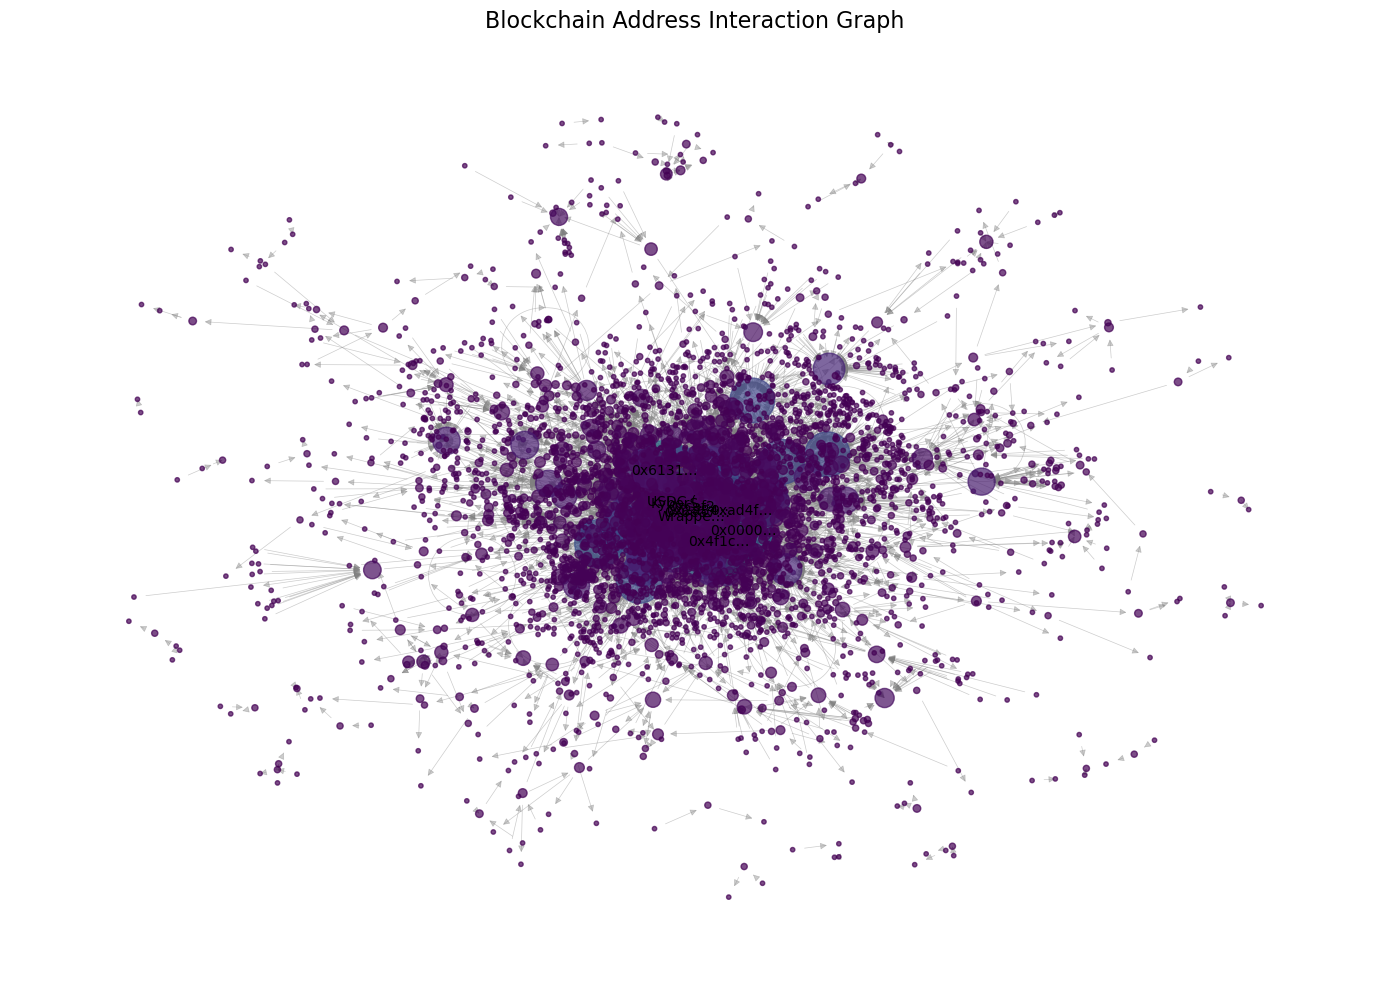

In [43]:
import matplotlib.pyplot as plt
import networkx as nx

# Use spring layout (force-directed, aesthetically pleasing)
pos = nx.spring_layout(G, seed=42, k=0.3)  # tweak k for spacing

# Node degrees for size and color
degrees = dict(G.degree())
node_sizes = [degrees[n] * 10 for n in G.nodes()]
node_colors = [degrees[n] for n in G.nodes()]

# Draw nodes
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.7
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    width=0.5,
    alpha=0.4,
    arrows=True
)

# Optionally draw labels (e.g., top nodes only)
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
top_node_labels = {n: n[:6] + "…" for n, _ in top_nodes}

nx.draw_networkx_labels(
    G, pos,
    labels=top_node_labels,
    font_size=10,
    font_color="black"
)

plt.title("Blockchain Address Interaction Graph", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [24]:
# import networkx as nx
# import plotly.graph_objects as go

# # Example: Use your actual graph G
# # pos = nx.spring_layout(G, seed=42)  # force-directed layout
# pos = nx.kamada_kawai_layout(G)  # often prettier for smaller graphs

# # Extract edge coordinates
# edge_x = []
# edge_y = []
# for u, v in G.edges():
#     x0, y0 = pos[u]
#     x1, y1 = pos[v]
#     edge_x.extend([x0, x1, None])
#     edge_y.extend([y0, y1, None])

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines'
# )

# # Extract node positions and hover info
# node_x = []
# node_y = []
# node_text = []
# node_size = []

# for node in G.nodes():
#     x, y = pos[node]
#     node_x.append(x)
#     node_y.append(y)

#     # Customize hover text
#     degree = G.degree[node]
#     node_text.append(f"Address: {node}<br>Degree: {degree}")

#     # Optional: scale node size
#     node_size.append(degree * 3 + 10)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     text=node_text,
#     marker=dict(
#         showscale=True,
#         colorscale='Viridis',
#         color=[G.degree(n) for n in G.nodes()],
#         size=node_size,
#         colorbar=dict(
#             thickness=15,
#             title='Node Degree',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2
#     )
# )

# # Build the figure
# fig = go.Figure(
#     data=[edge_trace, node_trace],
#     layout=go.Layout(
#         title='Blockchain Address Interaction Graph',
#         titlefont_size=16,
#         showlegend=False,
#         hovermode='closest',
#         margin=dict(b=20, l=5, r=5, t=40),
#         annotations=[dict(
#             text="Use scroll or drag to explore the network.",
#             showarrow=False,
#             xref="paper", yref="paper",
#             x=0.005, y=-0.002
#         )],
#         xaxis=dict(showgrid=False, zeroline=False),
#         yaxis=dict(showgrid=False, zeroline=False)
#     )
# )

# fig.show()

In [ ]:
from pyvis.network import Network

net = Network(height="10000px", width="10000px", notebook=True)
net.from_nx(G)
net.show("nx.html")

In [ ]:
from pyvis.network import Network
import networkx as nx
nx_graph = nx.cycle_graph(10)
nx_graph.nodes[1]['title'] = 'Number 1'
nx_graph.nodes[1]['group'] = 1
nx_graph.nodes[3]['title'] = 'I belong to a different group!'
nx_graph.nodes[3]['group'] = 10
nx_graph.add_node(20, size=20, title='couple', group=2)
nx_graph.add_node(21, size=15, title='couple', group=2)
nx_graph.add_edge(20, 21, weight=5)
nx_graph.add_node(25, size=25, label='lonely', title='lonely node', group=3)
nt = Network('500px', '500px', notebook=True)
# populates the nodes and edges data structures
nt.from_nx(nx_graph)
nt.show('nx.html')